<h1>Multi-Touch Attribution with Markov Chains Considering Number of Touches</h1>

The purpose of this notebook is to show an implementation of an augmented Markov chain where state variable is augmented by number of touches so far in the journey. Transition probabilities, attributions, ans some visual insights are also included. To review the first-order Markov chain solution to multi-touch attribution problem, see [Multi-Touch Attribution with First-Order Markov Chains](#https://blend360-measurement-library.readthedocs-hosted.com/en/latest/content/Customer%20Journey%20Analytics/Methodologies/Markov%20Chains/MTA_Markov%20chains_FirstOrder.html).

## 1. An augmented Markov model <a name="se:intro"></a>

This Markov chain model expands upon a first-order Markoc chain ([here](#https://blend360-measurement-library.readthedocs-hosted.com/en/latest/content/Customer%20Journey%20Analytics/Methodologies/Markov%20Chains/MTA_Markov%20chains_FirstOrder.html)) by also capturing the order of a particular channel in the customer's journey from start to conversion or loss. This Markov chain's state space is described by a state variable which stores both the current channel and the particular order of the current channel in the consumer's journey. Therefore, the transition probabilities in the second model depend on both the current channel and the number of touches up to current channel.

The augmented Markov model differentiates between transition probabilities from one channel to another by considering the number of clicks (touches) up to that point in the journey. Evaluating the transition probabilities, similar to first-order Markov chains requires capturing the frequency of all each particular transition with respect to all transitions sharing the same starting state or channel. However, this time the state space includes an additional element, i.e., `idx`, which stores the order of each state in a consumer's journey.

![MCv2.png](MCv2.png)

Similar to the first-order model, this Markov chain also includes a `Start` state and two absorbing states of `LOSS` and `CONVERSION`. Channel attribution is this setting is also evaluated by removal effects, however, since a channel is represented by mutliple state variables (each with a certain number of clicks), the attribution will be equal to the sum of `(channel, num of clicks)` attributions.

## 2. Read-in sample data base <a name="se:data"></a>

A sample data base is provided which consists of `601776` customer identifier keys and the customer journeys to conversion or loss. Customer journeys are created from raw customer interactions (clicks, impressions, etc.) where individual interactions are grouped by an customer identifer key (e.g., cookie id), sorted by a timestamp (e.g., time of interaction) and joined together. For more details, refer to [Data Transformation](#https://blend360-measurement-library.readthedocs-hosted.com/en/latest/content/Customer%20Journey%20Analytics/Methodologies/Markov%20Chains/MTA_Markov%20chains_FirstOrder.html#https://blend360-measurement-library.readthedocs-hosted.com/en/latest/content/Customer%20Journey%20Analytics/Data%20Transformations/index.html) section of [Customer Journey Analytics](#https://blend360-measurement-library.readthedocs-hosted.com/en/latest/content/Customer%20Journey%20Analytics/Methodologies/Markov%20Chains/MTA_Markov%20chains_FirstOrder.html#https://blend360-measurement-library.readthedocs-hosted.com/en/latest/content/Customer%20Journey%20Analytics/index.html). The sample data set is investigated to see no duplicate values are present in customer IDs. **NOTE** that this data set assumes only a homogeneous set of consumers.

In [1]:
import os
import inspect
import pandas as pd
curr_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(curr_dir)
path_df = pd.read_csv(os.path.join(parent_dir,
                                   "../Data Transformations/raw data/customer_journey_sample_data.csv"),
                      index_col = 0)
print(f'The data frame includes {list(path_df.columns)} columns \
and {len(path_df.PGM_FREQ_MEMBER_KEY.unique())} distinct rows')
path_df.head(5)

The data frame includes ['PGM_FREQ_MEMBER_KEY', 'CAM_DEV', 'CONVERSION'] columns and 601776 distinct rows


PGM_FREQ_MEMBER_KEY                                            CAM_DEV  \
0 -9223328556171841832  ['NATURAL SEARCH|DESKTOP', 'REFERRAL ENGINE|DE...   
1 -9223242021294710602  ['NATURAL SEARCH|DESKTOP', 'PAID SEARCH|DESKTOP']   
2 -9223227354203035958                                 ['DIRECT|DESKTOP']   
3 -9223216806413203389       ['DIRECT|DESKTOP', 'NATURAL SEARCH|DESKTOP']   
4 -9223197902225736847  ['NATURAL SEARCH|DESKTOP', 'DIRECT|DESKTOP', '...   

   CONVERSION  
0           1  
1           1  
2           0  
3           1  
4           1

**Stiching customer journeys and reducing the number of dimensions**: These two steps are already explained in details in training the first-order Markov chain in [Multi-Touch Attribution with First-Order Markov Chains](#https://blend360-measurement-library.readthedocs-hosted.com/en/latest/content/Customer%20Journey%20Analytics/Methodologies/Markov%20Chains/MTA_Markov%20chains_FirstOrder.html) notebook. The following cells are exactracted from the same notebook.

In [2]:
def add_start_absorbing_state_func(conversion, path):
    import ast
    path = ast.literal_eval(path)
    if conversion == 0:
        return ['Start'] + path + ['LOSS']
    else:
        return ['Start'] + path + ['CONVERSION']

path_df['FULL_PATH'] = path_df.apply(lambda x: add_start_absorbing_state_func(x['CONVERSION'], x['CAM_DEV']), axis = 1)

In [3]:
#extract all the unique states that are visited along all paths
unique_channel_lst = set(state for path in path_df.FULL_PATH for state in path)
print(unique_channel_lst)

{'B2B|DESKTOP', 'PAID SEARCH|DESKTOP', 'RESLINK|DESKTOP', 'PAID SEARCH|MOBILE', 'DIRECT|DESKTOP', 'OTHER|MOBILE', 'RESLINK|MOBILE', 'REFERRAL ENGINE|DESKTOP', 'DISPLAY|DESKTOP', 'AFFILIATE|MOBILE', 'SOCIAL MEDIA|MOBILE', 'EMAIL|MOBILE', 'Start', 'ECONFO AND PRE-ARRIVAL EMAIL|MOBILE', 'CONVERSION', 'REFERRAL ENGINE|MOBILE', 'UNPAID REFERRER|DESKTOP', 'DIRECT|MOBILE', 'ECONFO AND PRE-ARRIVAL EMAIL|DESKTOP', 'DISPLAY|MOBILE', 'UNPAID REFERRER|MOBILE', 'AFFILIATE|DESKTOP', 'EMAIL|DESKTOP', 'TEST|DESKTOP', 'SOCIAL MEDIA|DESKTOP', 'LOSS', 'NATURAL SEARCH|DESKTOP', 'NATURAL SEARCH|MOBILE', 'OTHER|DESKTOP'}


In [4]:
other_channel_lst = []
## uncomment below to reduce the number of states
other_channel_lst = ['ECONFO AND PRE-ARRIVAL EMAIL|MOBILE',
                     'ECONFO AND PRE-ARRIVAL EMAIL|DESKTOP',
                     'OTHER|MOBILE',
                     'OTHER|DESKTOP',
                     'UNPAID REFERRER|MOBILE',
                     'UNPAID REFERRER|DESKTOP',
                     'TEST|DESKTOP',
                     'B2B|DESKTOP',
                     'RESLINK|MOBILE',
                     'RESLINK|DESKTOP']
unique_channel_lst = set(channel if channel not in other_channel_lst else 'OTHER' for channel in unique_channel_lst)
print(unique_channel_lst - set(['Start', 'CONVERSION', 'LOSS']))

{'REFERRAL ENGINE|MOBILE', 'PAID SEARCH|DESKTOP', 'PAID SEARCH|MOBILE', 'DIRECT|MOBILE', 'OTHER', 'DIRECT|DESKTOP', 'REFERRAL ENGINE|DESKTOP', 'DISPLAY|DESKTOP', 'DISPLAY|MOBILE', 'AFFILIATE|MOBILE', 'SOCIAL MEDIA|MOBILE', 'EMAIL|MOBILE', 'AFFILIATE|DESKTOP', 'EMAIL|DESKTOP', 'SOCIAL MEDIA|DESKTOP', 'NATURAL SEARCH|DESKTOP', 'NATURAL SEARCH|MOBILE'}


## 3. Training the Markov model <a name="se:markov"></a>
The keys to the `transitions_freq_dict` dictionary have changed to a 3-tuple of `(from_channel, to_channel, num_touches)`. To count the number of transitions between a pair of states, existence of a particular of `(from_channel, to_channel, num_touches)` in the dictionary is checked. If the key does not exist in the dictionary, it is added and is initialized with a value of `1`. If the key exist, the count is increased by `+1`. Similar to first-order Markov chain training, going through each customer's journey in the `path_df` dataframe, all transitions are enumerated if the starting or ending state are not among the states in `other_channel_lst`. Otherwise, they are counted as a transition from, or a transition to `OTHER` state.

The resulting dictionary holds the frequency of each particular transition. To simplify evaluation of transition probabilities, the `transitions_freq_dict` is converted to a dataframe where dictionary keys construct the `transitions` column and dictionary values construct the `freq` column of the new `transitions_freq_df` dataframe. Then, the `transitions` column is further broken down to `from_channel`, `to_channel`, and `num_touches` columns. Finally, transition probabilities are calculated by dividing the frequency of each transition by the sum of all frequencies for transitions sharing the same `from_channel` and `num_touches`. 

In [5]:
from tqdm import tqdm
#count the number of each transition in data
transitions_freq_dict = {}
for row in tqdm(path_df.iterrows()):
    full_path = row[1]['FULL_PATH']
    for num_touches, channel in enumerate(full_path):
        path_len = len(full_path)
        from_channel = channel if channel in unique_channel_lst else 'OTHER'
        to_channel = full_path[num_touches + 1] if full_path[num_touches + 1] in unique_channel_lst else 'OTHER'
        if (from_channel, to_channel, num_touches, path_len) not in transitions_freq_dict.keys():
            transitions_freq_dict[(from_channel, to_channel, num_touches, path_len)] = 1
        else:
            transitions_freq_dict[(from_channel, to_channel, num_touches, path_len)] += 1
        if to_channel in ['CONVERSION', 'LOSS']:
            break

601776it [00:37, 15943.56it/s]


In [6]:
#convert the dictionary into data fram and add frq, from_state, and to_state columns
transitions_freq_df = pd.DataFrame.from_dict(transitions_freq_dict, orient = 'index', columns = ['freq'])
transitions_freq_df.reset_index(inplace = True)
transitions_freq_df.rename(columns = {'index': 'transitions'}, inplace = True)
transitions_freq_df[['from_channel', 'to_channel', 'num_touches', 'path_len']] = transitions_freq_df.transitions.tolist()
transitions_freq_df.head(5)

transitions   freq  \
0              (Start, NATURAL SEARCH|DESKTOP, 0, 6)  10183   
1  (NATURAL SEARCH|DESKTOP, REFERRAL ENGINE|DESKT...   1033   
2  (REFERRAL ENGINE|DESKTOP, NATURAL SEARCH|MOBIL...     23   
3  (NATURAL SEARCH|MOBILE, PAID SEARCH|MOBILE, 3, 6)    282   
4             (PAID SEARCH|MOBILE, CONVERSION, 4, 6)    327   

              from_channel               to_channel  num_touches  path_len  
0                    Start   NATURAL SEARCH|DESKTOP            0         6  
1   NATURAL SEARCH|DESKTOP  REFERRAL ENGINE|DESKTOP            1         6  
2  REFERRAL ENGINE|DESKTOP    NATURAL SEARCH|MOBILE            2         6  
3    NATURAL SEARCH|MOBILE       PAID SEARCH|MOBILE            3         6  
4       PAID SEARCH|MOBILE               CONVERSION            4         6

In [7]:
transitions_freq_agg_df = transitions_freq_df.groupby(['from_channel', 'to_channel', 'num_touches'])['freq'].sum().to_frame().reset_index()
transitions_freq_agg_df

from_channel               to_channel  num_touches  freq
0     AFFILIATE|DESKTOP         AFFILIATE|MOBILE            1    19
1     AFFILIATE|DESKTOP         AFFILIATE|MOBILE            2     9
2     AFFILIATE|DESKTOP         AFFILIATE|MOBILE            3     1
3     AFFILIATE|DESKTOP         AFFILIATE|MOBILE            4     6
4     AFFILIATE|DESKTOP         AFFILIATE|MOBILE            5     2
...                 ...                      ...          ...   ...
2398              Start       PAID SEARCH|MOBILE            0  4739
2399              Start  REFERRAL ENGINE|DESKTOP            0  4732
2400              Start   REFERRAL ENGINE|MOBILE            0   867
2401              Start     SOCIAL MEDIA|DESKTOP            0   436
2402              Start      SOCIAL MEDIA|MOBILE            0   159

[2403 rows x 4 columns]

In [8]:
#evalauate transition probabilities by dividing the frequencey 
transitions_freq_agg_df['prob'] = transitions_freq_agg_df['freq'] / \
                                  transitions_freq_agg_df.groupby(['from_channel', 'num_touches'])['freq'].transform('sum')
transitions_freq_agg_df = transitions_freq_agg_df[transitions_freq_agg_df.prob != 0]

In [9]:
transitions_mat = transitions_freq_agg_df.pivot(index = ['from_channel', 'num_touches'], 
                                            columns = 'to_channel', 
                                            values = 'prob')

#order of columns
ordered_column_lst = [channel for channel in sorted(transitions_freq_agg_df.to_channel.unique()) 
                                  if channel not in ['CONVERSION', 'LOSS', 'Start']]
ordered_column_lst = ordered_column_lst + ['CONVERSION', 'LOSS']

#order of rows
ordered_index_lst = [channel for channel in transitions_mat.index 
                                 if channel[0] not in ['Start', 'CONVERSION', 'LOSS']]
ordered_index_lst = [('Start', 0)] + ordered_index_lst

#reorder states, fill NaN with 0s, round probabilities to 2 decimals and remove
transitions_mat = transitions_mat.reindex(columns = ordered_column_lst)
transitions_mat = transitions_mat.reindex(index = ordered_index_lst)
transitions_mat = transitions_mat.fillna(0)
transitions_mat = transitions_mat.round(decimals = 2)

### 3.1. Transition probabilities: <a name="sse:markov-prob"></a>
To visualize the matrix of transition probabilities, `transitions_freq_df` is pivoted to a wide format where rows denote `from_channel` and number of `touches` and columns denote `to_channel`. 

Then, columns and rows are reordered such that rows start with the `Start` state and the rest of states, i.e., channels, are soreted alphabetically. Columns are sorted in a similar manner except there is no `Start` state and `CONVERSION` and `LOSS` states are moved to the end. A row (or column) with all `NaN` values indicates that no transition started from (or ended in) that particular state and thus they are removed.

The heatmap of transition probabilities is depcited next where lighter colors indicate higher transition probabilities. To interpret the heatmap of the transition probabilities, note that the number of touches is only reflected in rows. Therefore, to calculate the probability of a particular path, say, `Start -> Direct|Desktop -> Natural search|Desktop -> Paid search|Desktop -> CONVERSION` one has to consider that based on the first row of the below heatmap, transition from `Start-0` to `Direct|Desktop` has a 0.36 probability. This should be multiplied by the probability of transitioning from `Direct|Desktop-1` to `Natural search|Desktop` which is 0.18. Then, transition from `Natural search|Desktop-2` to `Paid search|Desktop` has 0.13 probability and finally transition from `Paid search|Desktop-3` to `CONVERSION` happens 0.28 of the times.

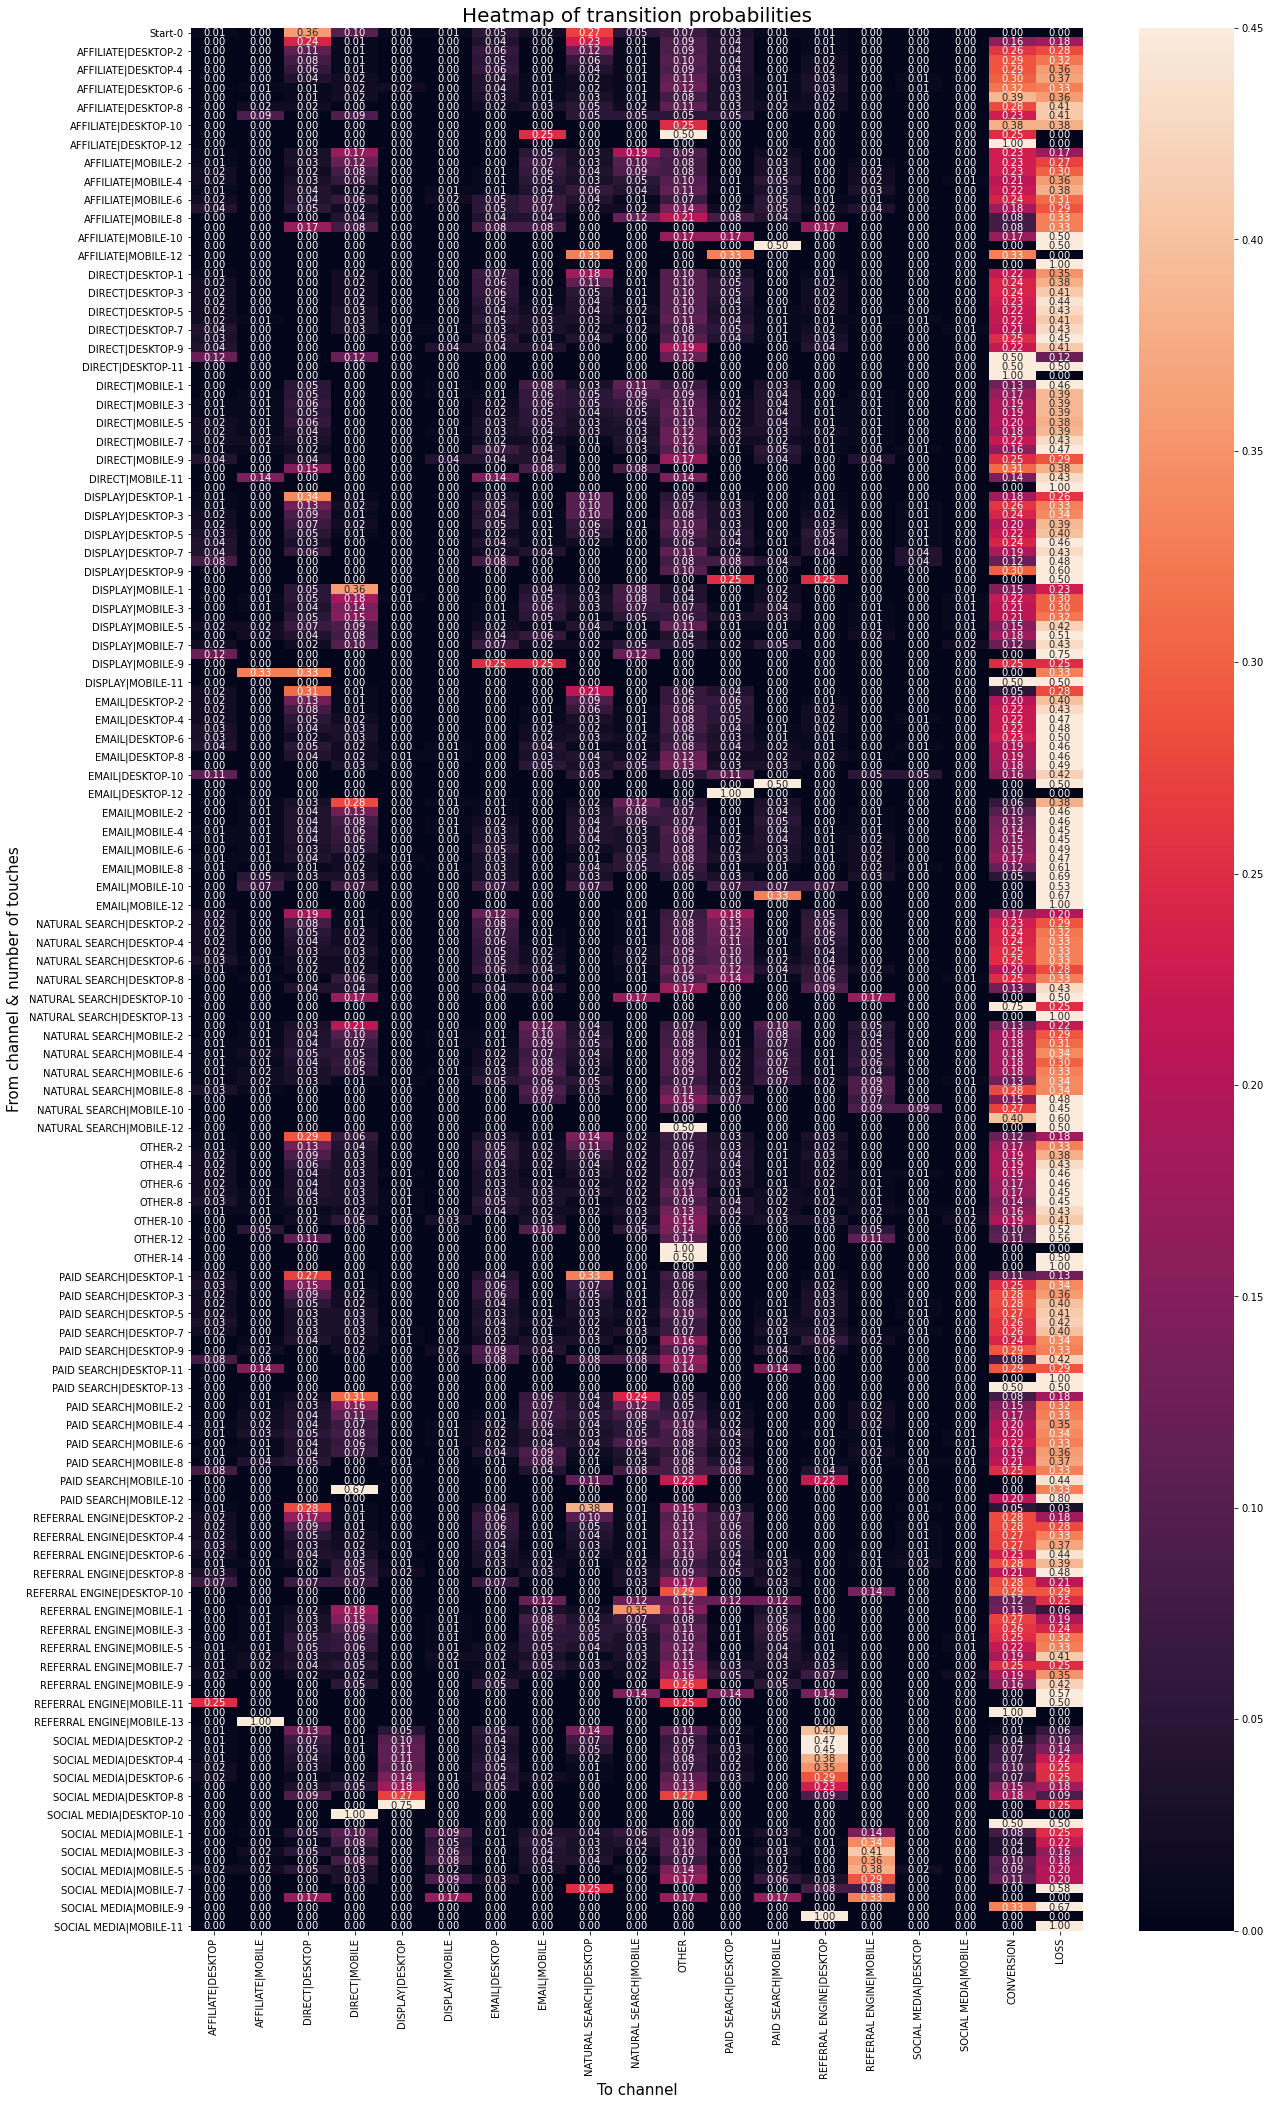

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig, ax = plt.subplots(figsize = (20, 35))
sns.heatmap(transitions_mat, annot = True, robust = True, fmt = ".2f")

plt.title('Heatmap of transition probabilities', fontsize = 20) # title with fontsize 20
plt.xlabel('To channel', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('From channel & number of touches', fontsize = 15) # y-axis label with fontsize 15

plt.show()

## 4. Attribution by removal effect <a name="se:attribution"></a>

The above transition probability describes the transition probabilities of an augmented Markov chain, however, it is not a true transition probability matrix ready for matrix algebra since row and column states are different and the matrix is not squared. The above representation is sufficient in describing all transition probabilities since the number of touches grow deterministically by 1 click in each transition. Therefore, the probability of going from `(EMAIL|DESKTOP, 2) -> AFFILIATE|DESKTOP` is equivalent to `(EMAIL|DESKTOP, 2) -> (AFFILIATE|DESKTOP, 3)`.

For calculating removal effects and attributions, a complete version of the transition probability matrix is required. To do that the following cells, add a `to_touches` column to the `transition_freq_df` data frame to capture the number of touches after transition. Then, channels are ordered from `Start` to `CONVERSION` and an empty `transitions_mat` data frame is created to include all potential combinations of `(from_channel, num_touches)` and `(to_channel, to_touches)` in column and row indecis. The new transition probability data frame is populated based on the `transition_freq_df` which leaves some transitions from rows empty of any transitions. That means that some combinations of channel and touches are not visited ever and thus they can be dropped from both rows and columns since for a transient state in Markov chains, a transition to the state means that there should be a transition from that state as well. Remaining `NaN` values are replaced with `0` and absorbing probabilities are added to states `LOSS` and `CONVERSION`.

**NOTE** that the number of touches for `Start`, `LOSS`, and `CONVERSION` is not recorded since `Start` is always at the begining of the journey and there are no transitions after `LOSS` or `CONVERSION`.

In [11]:
## add number of touches after transition
transitions_freq_agg_df['to_touches'] = transitions_freq_agg_df['num_touches'] + 1

## reorder column and row indecis
ordered_channel_list = list(sorted(unique_channel_lst - set(['Start', 'CONVERSION', 'LOSS'])))
ordered_channel_list = ['Start'] + ordered_channel_list + ['LOSS', 'CONVERSION']

## create an empty transition probability data frame
indecis = []
for channel in ordered_channel_list:
    if channel not in ['Start', 'LOSS', 'CONVERSION']:
        for num_touches in range(1, max(transitions_freq_agg_df.to_touches) + 1):
            indecis.append((channel, num_touches))
    else:
        indecis.append((channel, ))
transitions_mat = pd.DataFrame(columns = indecis, index = indecis)

## populate the transition probability data frame
for idx, row in transitions_freq_agg_df.iterrows():
    if row.from_channel == 'Start':
        transitions_mat[(row.to_channel, row.to_touches)][('Start',)] = row.prob
        #print(row.to_channel, row.to_touches)
    elif row.to_channel in ['LOSS', 'CONVERSION']:
        transitions_mat[(row.to_channel,)][(row.from_channel, row.num_touches)] = row.prob
    else:
        transitions_mat[(row.to_channel, row.to_touches)][(row.from_channel, row.num_touches)] = row.prob
        
## identify indecis with no transitions
isx_to_rem = []
for i in range(len(transitions_mat)):
    if transitions_mat.index[i][0] in ['LOSS', 'CONVERSION']:
        continue
    elif transitions_mat.iloc[i, ].sum() == 0 and transitions_mat.index[i][0] not in ['LOSS', 'CONVERSION']:
        isx_to_rem.append(transitions_mat.index[i])
    elif round(transitions_mat.iloc[i, ].sum()) != 1:
        raise ValueError(f'Error: Transition probabilities in row {transitions_mat.index[i]} do not sum to 1.')
        
## clean up the transition probability matrix
transitions_mat.drop(index = isx_to_rem, columns = isx_to_rem, inplace = True)
transitions_mat = transitions_mat.fillna(0)
transitions_mat.loc[transitions_mat.index == ('LOSS', ), [('LOSS', )]] = 1
transitions_mat.loc[transitions_mat.index == ('CONVERSION', ), [('CONVERSION', )]] = 1

The `removal_effects` function below is extracte from the [Multi-Touch Attribution with First-Order Markov Chains](#https://blend360-measurement-library.readthedocs-hosted.com/en/latest/content/Customer%20Journey%20Analytics/Methodologies/Markov%20Chains/MTA_Markov%20chains_FirstOrder.html) notebook, **Section 4**. The algorithm is explained in details in the same notebook. Here, only minor tweaks are applied to make the function compatible with a transition probability matrix that has tuples as its indecis in rows and columns. Removal effects of all combinations of channels and number of touches are evaluated afterwards. Attributions in this setting will be normalized removal effects multiplied by total conversion.

In [12]:
def removal_effects(transitions_mat, base_conversion_rate):
    import numpy as np
    from tqdm import tqdm
    RE_dict = {}
    channels = [channel for channel in transitions_mat.columns
                            if channel[0] not in ['Start', 'LOSS', 'CONVERSION']]
    for channel in tqdm(channels):
        #remove a channel from TPM by dropping it from rows and columns
        removal_df = transitions_mat.drop(channel, axis = 1).drop(channel, axis = 0)
        for column in removal_df.columns:
            #calculate the drop in conversion rate
            row_sum = np.sum(list(removal_df.loc[[column]].values))
            null_pct = float(1) - row_sum
            if null_pct != 0:
                removal_df.loc[[column]][('LOSS', )] = null_pct
            removal_df.loc[[('LOSS', )]][('LOSS', )] = 1.0
        #partition T and R matrix from the reduced transition matrix
        R = removal_df[[('LOSS', ), ('CONVERSION', )]].drop([('LOSS', ), ('CONVERSION', )], axis = 0)
        T = removal_df.drop([('LOSS', ), ('CONVERSION', )], axis = 1).drop([('LOSS', ), ('CONVERSION', )], axis = 0)
        I = np.identity(len(T.columns))
        #calculate absorbtion probabilities for the reduced matrix, 0: loss probabilities, 1: conversion probabilities
        P = np.dot(np.linalg.inv(I - T), np.asarray(R))
        #extract the new conversion rate from the `Start` state
        new_cr = pd.DataFrame(P, index = R.index)[[1]].loc[[('Start', )]].values[0]
        RE = 1 - new_cr / base_conversion_rate
        RE_dict[channel] = RE
    #sum of removal effects
    re_sum = np.sum(list(RE_dict.values()))
    #normalize the removal effect
    new_RE_dict = {k: v / re_sum for k, v in RE_dict.items()}
    return RE_dict, new_RE_dict

In [13]:
total_conversions = sum(path.count('CONVERSION') for path in path_df['FULL_PATH'].tolist())
base_conversion_rate = total_conversions / len(path_df['FULL_PATH'])
removal_effects_dict, normalized_removal_effects_dict = removal_effects(transitions_mat, base_conversion_rate)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 204/204 [00:43<00:00,  4.65it/s]


In [14]:
new_attributions = {k:v  * total_conversions for k, v in normalized_removal_effects_dict.items()}
new_attributions = pd.DataFrame.from_dict(new_attributions, orient = 'index', columns = ['attribution'])
new_attributions.reset_index(inplace = True)
new_attributions.rename(columns = {'index': 'channel'}, inplace = True)
new_attributions.sort_values(by = 'attribution', ascending = False, inplace = True)
new_attributions.reset_index(drop = True, inplace = True)
new_attributions

channel   attribution
0             (DIRECT|DESKTOP, 1)  4.203092e+04
1     (NATURAL SEARCH|DESKTOP, 1)  3.460039e+04
2     (NATURAL SEARCH|DESKTOP, 2)  1.370302e+04
3             (DIRECT|DESKTOP, 2)  1.291725e+04
4                      (OTHER, 1)  8.775357e+03
..                            ...           ...
199  (NATURAL SEARCH|DESKTOP, 13)  1.528393e-10
200   (NATURAL SEARCH|MOBILE, 12)  1.528393e-10
201                   (OTHER, 13)  1.528393e-10
202     (PAID SEARCH|DESKTOP, 12)  1.528393e-10
203     (SOCIAL MEDIA|MOBILE, 11)  1.528393e-10

[204 rows x 2 columns]

### 4.1. Visualizing channel-journey length attribution <a name="sse:attr-viz"></a>

The total number of unique combinations of channels and number of touches are `203`. In other words, each channel gets a different attribution for different journey lengths. Visualizing `203` attributions in a meaningful way is attempted below by a bubble chart. The size of the bubble is proportional to the attribution. Before plotting the chart, the `new_attributions` data frame column of `channel` is splitted into separate columns of `channel` and `touches`.

In [15]:
new_attributions[['channel', 'touches']] = pd.DataFrame(new_attributions['channel'].tolist(), 
                                                        index = new_attributions.index)

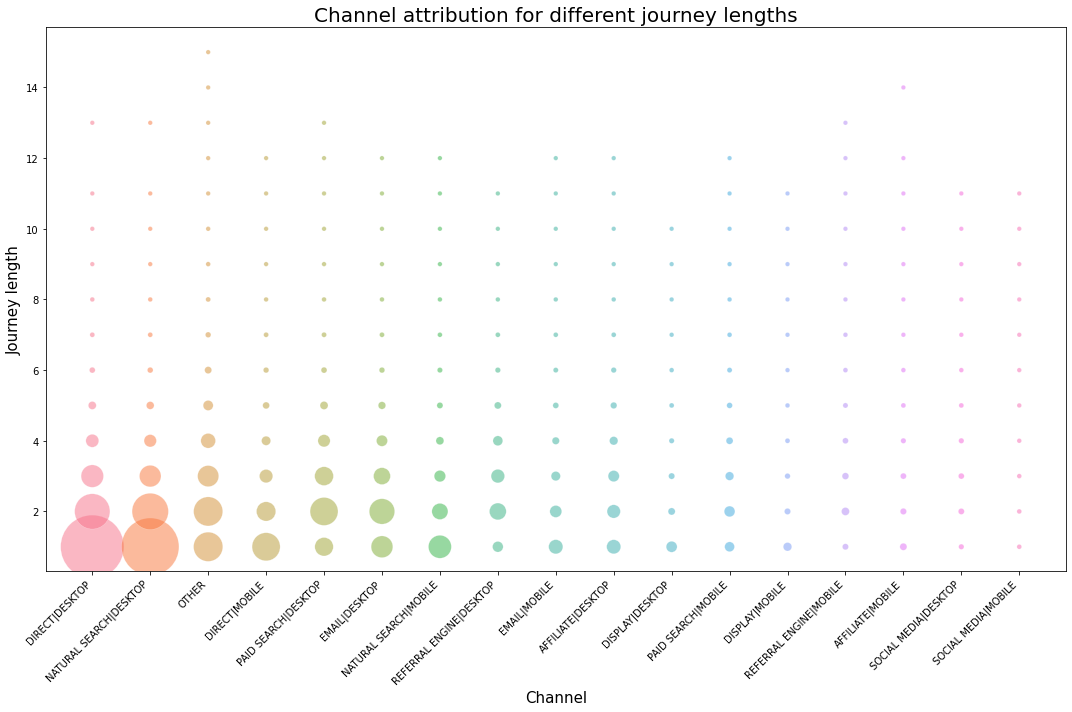

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig, ax = plt.subplots(figsize = (15, 10))
g = sns.scatterplot(x = 'channel', 
                    y = 'touches',
                    size ='attribution',
                    alpha = 0.5,
                    sizes = (20, 4000),
                    hue = 'channel',
                    data = new_attributions,
                    legend = False)

#for index, row in new_attributions.iterrows():
#    g.text(row.name,
#           row.attribution + 100,
#           str(round(row.attribution, 2)) + "\n" + str(round(row.per * 100, 2)) + "%",
#           color = 'black',
#           ha = "center")

plt.draw()
g.set_xticks(list(range(len(new_attributions.channel.unique()))))
g.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right')
plt.title('Channel attribution for different journey lengths', fontsize = 20) # title with fontsize 20
plt.xlabel('Channel', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Journey length', fontsize = 15) # y-axis label with fontsize 15
plt.tight_layout()
plt.show()

### 4.2. Aggregated attribution <a name="sse:attr-agg"></a>

Attributions can be aggregated by channel which will sum attribution of a channel across different journey lenghts. Below, aggregated attributions of the augmented Markov chain model are compared with the first-order Markov chain. **NOTE** that both Markov models are based on similar data sets. The first-order Markov chain attribution graph is extracted from the [Multi-Touch Attribution with First-Order Markov Chains](#https://blend360-measurement-library.readthedocs-hosted.com/en/latest/content/Customer%20Journey%20Analytics/Methodologies/Markov%20Chains/MTA_Markov%20chains_FirstOrder.html) notebook.

In [17]:
temp_attributions = new_attributions.groupby('channel')['attribution'].sum().to_frame().reset_index()
temp_attributions['per'] = temp_attributions.attribution / temp_attributions.attribution.sum()
temp_attributions.sort_values(by = 'attribution', ascending = False, inplace = True)
temp_attributions.reset_index(drop = True, inplace = True)

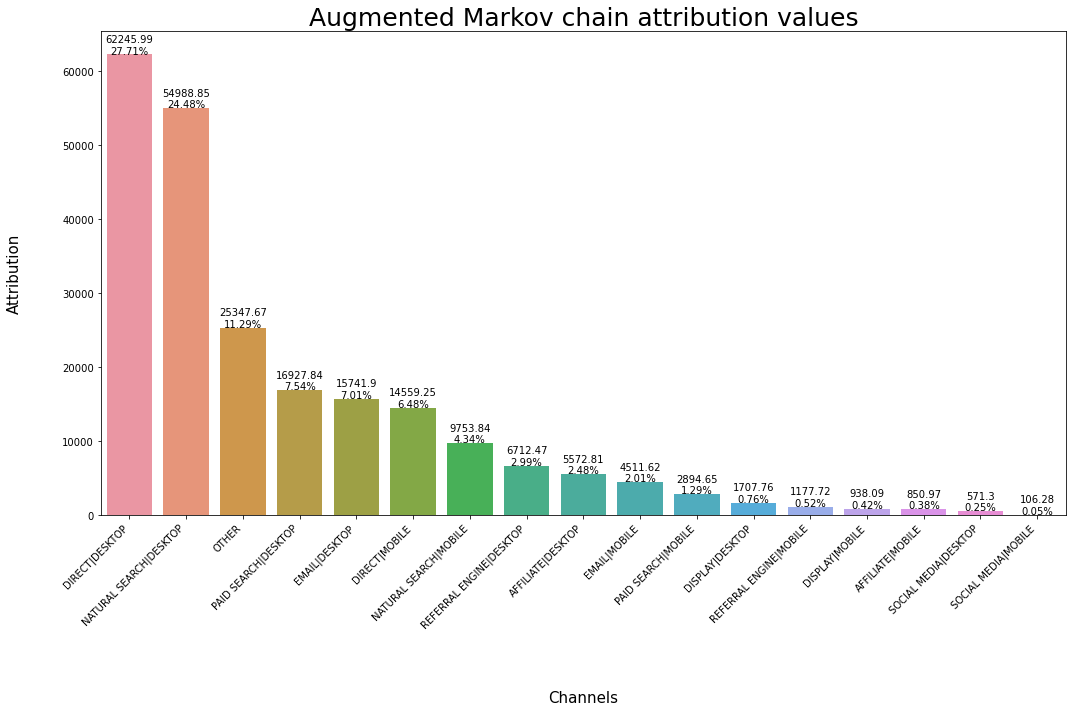

In [18]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

fig, ax = plt.subplots(figsize = (15, 10))
g = sns.barplot(x = 'channel',
                y = 'attribution',
                data = temp_attributions,
                ax = ax)

for index, row in temp_attributions.iterrows():
    g.text(row.name,
           row.attribution + 100,
           str(round(row.attribution, 2)) + "\n" + str(round(row.per * 100, 2)) + "%",
           color = 'black',
           ha = "center")

g.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right')
g.set_title('Augmented Markov chain attribution values', fontsize = 25)
plt.xlabel("Channels", labelpad = 60, fontsize = 15)
plt.ylabel("Attribution", labelpad = 40, fontsize = 15)
plt.tight_layout()
plt.show()

The above figure shows the aggregated attributions of the augmented Markov chain model while the figure below shows a the attribution results of a first-order Markov chain. Both models have been trained over the same data. As can be seen, it seems that the augmented Markov chain model assigns more attribution to the most frequent channels when compared to the first-order model. Conversely, the first-order Markov model assigns more attribution to the infrequent channels. This result should be understood in addition to the accuracy of both models which, currently, is a work in progress.

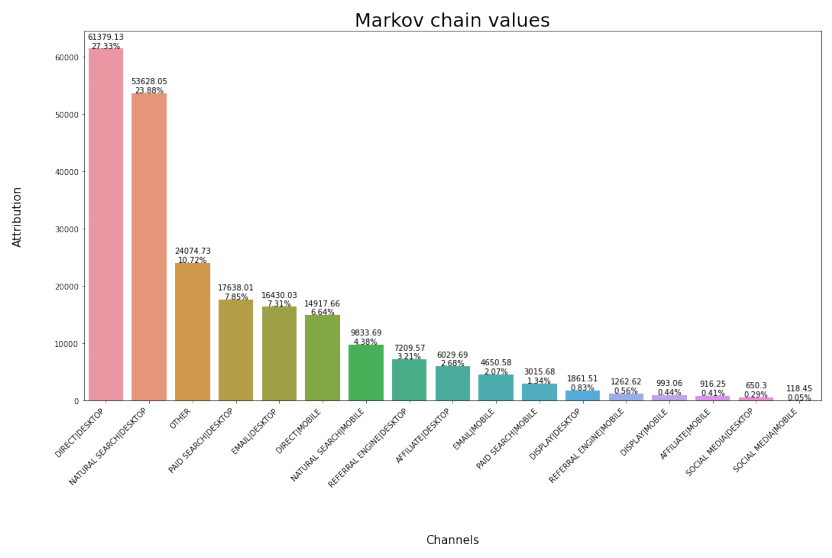

In [19]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

fig, ax = plt.subplots(figsize = (15, 10))
img = mpimg.imread('MTA_Markov_chains_FirstOrder.png')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

### 4.3. Attribution for different journey lenghts <a name="sse:attr-len"></a>

An advantage of the augmented Markov chain is the granular attribution it provides for at different number of touches in the customer journey. In other words, one can gain insights into what is the contribution of each channel in converting customers at different journey lengths.

Below, the channel with the most attribution at different journey lenghts is extracted. **NOTE** that channel `OTHER` is removed from this analysis since it represents multiple channels aggregated into one channel to ease computation.

In [20]:
temp_attributions = new_attributions.copy(deep = True)
temp_attributions = temp_attributions.loc[temp_attributions.channel != 'OTHER',]
temp_attributions.loc[temp_attributions.groupby('touches')['attribution'].idxmax(), ['channel', 'touches']]

channel  touches
0            DIRECT|DESKTOP        1
2    NATURAL SEARCH|DESKTOP        2
10           DIRECT|DESKTOP        3
26           DIRECT|DESKTOP        4
44      PAID SEARCH|DESKTOP        5
68      PAID SEARCH|DESKTOP        6
87      PAID SEARCH|DESKTOP        7
111          DIRECT|DESKTOP        8
125     PAID SEARCH|DESKTOP        9
140           EMAIL|DESKTOP       10
155  NATURAL SEARCH|DESKTOP       11
167        AFFILIATE|MOBILE       12
173          DIRECT|DESKTOP       13
193        AFFILIATE|MOBILE       14

## 5. Step-wise analysis of channel contributions <a name="se:sankey"></a>

Below, a sankey diagram is drawn in an attempt to visualize the most probable transition flows. The overall sankey diagram will be too populated and could not be informative, therefore, in the following plot, only transition flows with less than 5 touches are considered. To further simplify the Sankey diagram, attributions across devices are aggregated and transitions to or from channel `OTHER` are ignored.

A Sankey diagram is constructed of transitions identified by a `source` node, a `target` node, and a `value` which in this case is set to be number of visits. Therefore, in the Sankey diagram below, the wider transition flow correspond to higher traffics. The chart below is also interactive and hovering a curser above each node or path will reveal its traffic values.

In [21]:
temp_transitions_freq_df = transitions_freq_df.copy(deep = True)
temp_transitions_freq_df[['from_channel', 'from_device']] = pd.DataFrame(transitions_freq_df.from_channel\
                                                                                            .str.split('|', 
                                                                                                       expand = True),
                                                                         index = transitions_freq_df.index)
temp_transitions_freq_df[['to_channel', 'to_device']] = pd.DataFrame(transitions_freq_df.to_channel\
                                                                                        .str.split('|', 
                                                                                                   expand = True),
                                                                     index = transitions_freq_df.index)

In [22]:
transitions_freq_agg = temp_transitions_freq_df.loc[(temp_transitions_freq_df.num_touches <= 5) & 
                                                    (temp_transitions_freq_df.from_channel != 'OTHER') & 
                                                    (temp_transitions_freq_df.to_channel != 'OTHER'), ]\
                                               .reset_index()
transitions_freq_agg = transitions_freq_agg.groupby(['from_channel', 'to_channel', 'num_touches'])['freq']\
                                           .sum()\
                                           .to_frame()\
                                           .reset_index()

In [23]:
labels = ["-".join([row.from_channel, str(row.num_touches)]) 
          for idx, row in transitions_freq_agg.iterrows() 
              if row.from_channel != 'Start'] + ['Start', 'CONVERSION', 'LOSS']
labels = list(set(labels))
source = []
target = []
value = []

for idx, row in transitions_freq_agg.iterrows():
    from_touches = row.num_touches
    to_touches = from_touches + 1
    if to_touches <= 5:
        if row.from_channel != 'Start':
            source.append(labels.index("-".join([row.from_channel, str(from_touches)])))
        else:
            source.append(labels.index(row.from_channel))
        if row.to_channel not in ['LOSS', 'CONVERSION']:
            target.append(labels.index("-".join([row.to_channel, str(to_touches)])))
        else:
            target.append(labels.index(row.to_channel))
        value.append(row.freq)

In [24]:
import plotly.graph_objects as go
import plotly.offline as py
%matplotlib inline

fig = go.Figure(data=[go.Sankey(
    arrangement = "snap",
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = labels
    ),
    link = dict(
      source = source, 
      target = target,
      value = value,
      label = value
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10, height=1000)
fig.show()